In [1]:
import mdptoolbox
import matplotlib.pyplot as plt
import numpy as np
import scipy.sparse as ss
import warnings
warnings.filterwarnings('ignore', category=ss.SparseEfficiencyWarning)

In [20]:
# params
alpha = 0.4
T = 8
state_count = (T+1) * (T+1)
epsilon = 10e-5

# game
action_count = 3
adopt = 0; override = 1; wait = 2

# mapping utils
state_mapping = {}
states = []
count = 0
for a in range(T+1):
    for h in range(T+1):
            state_mapping[(a, h)] = count
            states.append((a, h))
            count += 1

# initialize matrices
transitions = []; reward_selfish = []; reward_honest = []
for _ in range(action_count):
    transitions.append(ss.csr_matrix(np.zeros(shape=(state_count, state_count))))
    reward_selfish.append(ss.csr_matrix(np.zeros(shape=(state_count, state_count))))
    reward_honest.append(ss.csr_matrix(np.zeros(shape=(state_count, state_count))))

In [21]:
# populate matrices
for state_index in range(state_count):
    a, h = states[state_index]

    # adopt transitions
    transitions[adopt][state_index, state_mapping[1, 0]] = alpha
    transitions[adopt][state_index, state_mapping[0, 1]] = 1 - alpha
    # adopt rewards
    reward_honest[adopt][state_index, state_mapping[1, 0]] = h
    reward_honest[adopt][state_index, state_mapping[0, 1]] = h

    # override
    if a > h:
        transitions[override][state_index, state_mapping[a-h, 0]] = alpha
        reward_selfish[override][state_index, state_mapping[a-h, 0]] = h+1
        transitions[override][state_index, state_mapping[a-h-1, 1]] = 1 - alpha
        reward_selfish[override][state_index, state_mapping[a-h-1, 1]] = h+1
    else:
        transitions[override][state_index, 0] = 1
        reward_honest[override][state_index, 0] = 10000

    # wait transitions
    if (a < T) and (h < T):
        transitions[wait][state_index, state_mapping[a+1, h]] = alpha
        transitions[wait][state_index, state_mapping[a, h+1]] = 1 - alpha
    else:
        transitions[wait][state_index, 0] = 1
        reward_honest[wait][state_index, 0] = 10000

In [22]:
low = 0; high = 1
while (high - low) > epsilon / 8:
    rho = (low + high) / 2
    print(low, high, rho)
    total_reward = []
    for i in range(action_count):
        total_reward.append((1-rho)*reward_selfish[i] - rho*reward_honest[i])
    rvi = mdptoolbox.mdp.RelativeValueIteration(transitions, total_reward, epsilon/8)
    rvi.run()
    if rvi.average_reward > 0:
        low = rho
    else:
        high = rho
policy = rvi.policy
print('alpha: ', alpha, 'lower bound reward:', rho)

0 1 0.5
0 0.5 0.25
0.25 0.5 0.375
0.375 0.5 0.4375
0.4375 0.5 0.46875
0.46875 0.5 0.484375
0.46875 0.484375 0.4765625
0.46875 0.4765625 0.47265625
0.46875 0.47265625 0.470703125
0.46875 0.470703125 0.4697265625
0.4697265625 0.470703125 0.47021484375
0.47021484375 0.470703125 0.470458984375
0.47021484375 0.470458984375 0.4703369140625
0.47021484375 0.4703369140625 0.47027587890625
0.47021484375 0.47027587890625 0.470245361328125
0.47021484375 0.470245361328125 0.4702301025390625
0.47021484375 0.4702301025390625 0.47022247314453125
alpha:  0.4 lower bound reward: 0.47022247314453125


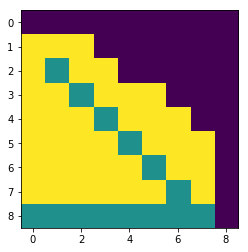

In [24]:
plt.imshow(np.reshape(policy, (9,9)))